<a id='head'></a>

# Определение перспективного тарифа для телеком-компании

## Оглавление
 
- [**Введение**](#intro)
    - [Описание тарифов](#tarif)
    - [Входные данные](#input_data)
    - [Цели исследования](#purpose)
    - [Ход исследования](#progress)
    
- [**1. Обзор данных**](#review)
    - [1.1 Импорт библиотек и таблиц](#review_01)
    - [1.2 Предварительное знакомство с данными](#review_02)
    - [Выводы](#review_conclusions)

- [**2. Предобработка данных**](#preprocessing)
    - [2.1 Информация о звонках](#preprocessing_01)
    - [2.2 Информация об интернет-сессиях](#preprocessing_02)
    - [2.3 Информация о сообщениях](#preprocessing_03)
    - [2.4 Информация о пользователях](#preprocessing_04)
    - [Выводы](#preprocessing_conclusions)
- [**3. Расчёты и дообогащение таблицы данными**](#data_enrichment)
    - [3.1 Звонки](#data_enrichment_01)
    - [3.2 Сообщения](#data_enrichment_02)
    - [3.3 Интернет трафик](#data_enrichment_03)
    - [3.4 Выручка](#data_enrichment_04)
    - [Выводы](#data_enrichment_conclusions)
- [**4. Исследовательский анализ данных**](#research)
    - [4.1 Исследование времени разговора пользователей](#research_01)
    - [4.2 Исследование количества сообщений пользователей](#research_02)        
    - [4.3 Исследование трафика пользователей](#research_03)
    - [4.4 Исследование выручки спользователей](#research_04)
    - [Выводы](#research_conclusions)
- [**5. Проверка гипотез**](#hypotheses)
    - [5.1 Выручка от пользователей тарифов «Ультра» и «Смарт»](#hypotheses_01)
    - [5.2 Выручка от пользователей из Москвы и других регионов](#hypotheses_02)

- [**6. Общий вывод**](#final_conclusion)
    - [6.1 Обзор данных](#final_conclusion_01)
    - [6.2 Предобработка данных](#final_conclusion_02)
    - [6.3 Расчеты и дообогщение таблицы](#final_conclusion_03)
    - [6.4 Исследовательский анализ данных](#final_conclusion_04)
    - [6.5 Проверка гипотез](#final_conclusion_05)

<a id='intro'></a>
## Введение [▴](#head)

Мы аналитики компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: `«Смарт»` и `«Ультра»`. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<a id='tarif'></a>
### Описание тарифов [▴](#head)

<p style="text-align: center;"><b>Тариф «Смарт»</b> - ежемесячная плата: <b>550 рублей</b></p>

Тип связи|Включено в тариф|Плата за превышение
-|-|-
Звонки|500 минут|3 руб. / минута
Сообщения|50 смс|3 руб. / смс
Интернет|15 Гб.|200 руб. / 1 Гб.

------

<p style="text-align: center;"><b>Тариф «Ультра»</b> - ежемесячная плата: <b>1950 рублей</b></p>

Тип связи|Включено в тариф|Плата за превышение
-|-|-
Звонки|3000 минут|1 руб. / минута
Сообщения|1000 смс|1 руб. / смс
Интернет|30 Гб.|150 руб. / 1 Гб.



**Примечание**
- «Мегалайн» всегда **округляет секунды до минут**, а **мегабайты — до гигабайт**. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

<a id='input_data'></a>
### Входные данные [▴](#head)

**Нам предоставили следующие таблицы:**
- `/datasets/calls.csv`
- `/datasets/internet.csv`
- `/datasets/messages.csv`
- `/datasets/tariffs.csv`
- `/datasets/users.csv`

**Таблица users** (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

**Таблица calls** (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица messages** (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица internet** (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

**Таблица tariffs** (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

<a id='purpose'></a>
### Цели исследования [▴](#head)

**Проанализировать**
- поведение клиентов
- сделать вывод какой тариф прибыльнее

**Проверить гипотезы:**
- средняя выручка пользователей тарифов `«Ультра»` и `«Смарт»` различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Дополнительно пояснить:**
- как формулировалась нулевая и альтернативная гипотеза;
- какой критерий использовался для проверки гипотез и почему.

<a id='progress'></a>
### Ход исследования [▴](#head)

[**Обзор данных**](#review)

[**Предобработка данных**](#preprocessing)
- Приведене данных к нужным типам;
- Поиск и устранение ошибок в данных, если они есть.
- Требуется пояснить, какие ошибки были найдены и как исправленны. 
- Примечание: в данных есть звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

[**Расчёты и дообогащение таблицы данными**](#data_enrichment)

Требуется посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (надо вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).


[**Исследовательский анализ данных**](#research)

- Требуется описать поведение клиентов оператора, исходя из выборки. 
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- Посчитать среднее количество, дисперсию и стандартное отклонение. 
- Построить гистограммы.
- Описать распределения.

[**Проверка гипотез**](#hypotheses)

[**Общий вывод**](#final_conclusion)








<a id='review'></a>
## 1. Обзор данных

<a id='review_01'></a>
### 1.1 Импорт библиотек и таблиц [▴](#head)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# для того чтобы код работал локально и на Практикуме применим конструкцию try-except
try:
    df_calls = pd.read_csv('/datasets/calls.csv')
    df_internet = pd.read_csv('/datasets/internet.csv')
    df_messages = pd.read_csv('/datasets/messages.csv')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
    df_users = pd.read_csv('/datasets/users.csv')
except:
    df_calls = pd.read_csv('datasets/calls.csv')
    df_internet = pd.read_csv('datasets/internet.csv')
    df_messages = pd.read_csv('datasets/messages.csv')
    df_tariffs = pd.read_csv('datasets/tariffs.csv')
    df_users = pd.read_csv('datasets/users.csv')

Присвоим имена таблицам.

In [2]:
df_calls.name = 'Информация о звонках'
df_internet.name = 'Информация об интернет-сессиях'
df_messages.name = 'Информация о сообщениях'
df_tariffs.name = 'Информация о тарифах'
df_users.name = 'Информация о пользователях'

<a id='review_02'></a>
### 1.2 Предварительное знакомство с данными [▴](#head)

Осмотрим каждую таблицу отдельно, и запишем необходимые доработки.

Для того чтобы не писать каждый раз по несколько одинаковых строк кода, напишем небольшую функцию:

In [3]:
def research(df):
    display(df.name, df)
    print(df.info())
    display(df.describe())
    print('Количество явных дубликатов:', df.duplicated().sum())

#### Информация о звонках

In [4]:
research(df_calls)

'Информация о звонках'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Количество явных дубликатов: 0


**Доработки для `df_calls`:**
- `call_date` - дата записана как текст, требуется сконвертировать в `DateTime`
- `duration` - требуется сконверитировать из `float64` в `int` с округлением вверх, так как время звонка округляется до минут.

#### Информация об интернет-сессиях

In [5]:
research(df_internet)

'Информация об интернет-сессиях'

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Количество явных дубликатов: 0


**Доработки для `df_internet`:**
- `Unnamed: 0` - паразитный столбец с индексами, требуется удалить
- `session_date` - дата записана как текст, требуется сконвертировать в `DateTime`

#### Информация о сообщениях

In [6]:
research(df_messages)

'Информация о сообщениях'

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


Количество явных дубликатов: 0


**Доработки для `df_messages`:**
- `message_date` - дата записана как текст, требуется сконвертировать в DateTime


#### Информация о тарифах

In [7]:
research(df_tariffs)

'Информация о тарифах'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


Количество явных дубликатов: 0


Тут все в порядке, доработок не требуется.

#### Информация о пользователях

In [8]:
research(df_users)

'Информация о пользователях'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Количество явных дубликатов: 0


Проверим текстовые поля на неявные дубликаты.

In [9]:
# для начала посмотрим количество уникальнеых значений в столбцах с текстовыми данными

for i in ['city', 'first_name', 'last_name', 'tariff']:
    print(i, len(df_users[i].unique()))

print()    

# теперь пройдемся по тем же столбцам, только предварительно
# заменим значения, которые могут создавать неявные дубликаты: " " "-" "ё"

for i in ['city', 'first_name', 'last_name', 'tariff']:
    print(i,
        len(
            df_users[i]
            .str.lower()
            .str.replace(' ', '')
            .str.replace('-', '')
            .str.replace('ё', 'е')
            .unique()
        )
    )

city 76
first_name 246
last_name 419
tariff 2

city 76
first_name 246
last_name 416
tariff 2


Видно что количество уменьшилось только в поле `last_name`. Скорей всего это некритично для нас, только проверим все ли `user_id` уникальны.

In [10]:
len(df_users.user_id.unique())

500

500 из 500 уникальны. Все в порядке, неявные дубликаты в поле `last_name` не помешают в нашем исследовании.

**Доработки для `df_users`:**
- `churn_date` - дата записана как текст, требуется сконвертировать в `DateTime`
- `reg_date` - дата записана как текст, требуется сконвертировать в `DateTime`


<a id='review_conclusions'></a>
### Выводы [▴](#head)

В трех разных таблицах `df_calls`, `df_messages`, `df_internet` встречается столбец с одинаковым именем `id`, более того, в каждой из таблиц он содержит очень похожую информацию. Переименуем заголовки этих столбцов, чтобы потом не было проблем при сшивании таблиц.

**df_calls**
- `id` — уникальный номер звонка, переименуем в `call_id`
- `call_date` - Дата записана как текст, требуется сконвертировать в `DateTime`
- `duration` - требуется сконверитировать из `float64` в `int` с округлением вверх, так как время звонка округляется до минут.

**df_internet**
- `id` — уникальный номер сессии, переименуем в `session_id`
- `Unnamed: 0` - Паразитный столбец с индексами, требуется удалить
- `session_date` - Дата записана как текст, требуется сконвертировать в `DateTime`

**df_messages**
- `id` — уникальный номер сообщения, переименуем в `message_id`
- `message_date` - дата записана как текст, требуется сконвертировать в `DateTime`

**df_tariffs**
- действий не требуется

**df_users**
- `churn_date` - дата записана как текст, требуется сконвертировать в `DateTime`
- `reg_date` - дата записана как текст, требуется сконвертировать в `DateTime`

Явных дубликатов ни в одной из таблиц не обнаружено. Все заголовки используют хороший стиль написания и не содержат пробелов, переименовывать их не нужно.

На первый взгляд, данных в предоставленных нам таблиц, достаточно для решения нашей задачи. Приступим к предобработке.

<a id='preprocessing'></a>
## 2. Предобработка данных

<a id='preprocessing_01'></a>
### 2.1 Информация о звонках [▴](#head)

In [11]:
# переименуем столбец id в call_id
df_calls.rename(columns={'id': 'call_id'}, inplace=True)

# приведем дату к нужному типу
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

# время звонков округлим до целого вверх и поменяем тип данных с float на int
df_calls['duration'] = df_calls['duration'].apply(np.ceil) # применим функцию округления из библиотеки numpy
df_calls['duration'] = df_calls['duration'].astype(int)

Выполнено, теперь проверим что все в порядке:

In [12]:
print(df_calls.info()) 
print(df_calls['duration'].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   call_id    202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB
None
0     0
1     0
2     3
3    14
4     6
Name: duration, dtype: int32


- тип данных в порядке
- столбец переименован
- время звонка целочисленное и округлено вверх

<a id='preprocessing_02'></a>
### 2.2 Информация об интернет-сессиях [▴](#head)

In [13]:
# переименуем столбце id в session_id
df_internet.rename(columns={'id': 'session_id'}, inplace=True)

# приведем дату к нужному типу
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

# удалим паразитный столбец методом drop
df_internet.drop('Unnamed: 0', axis=1, inplace=True)

Проверяем, что все отработало:

In [14]:
print(df_internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB
None


- тип данных в порядке
- столбец переименован
- паразитный столбец удален

<a id='preprocessing_03'></a>
### 2.3 Информация о сообщениях [▴](#head)

In [15]:
# переименуем столбце id в message_id
df_messages.rename(columns={'id': 'message_id'}, inplace=True)

# приведем дату к нужному типу
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

Проверяем, что все отработало:

In [16]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   message_id    123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


- тип данных в порядке
- столбец переименован

<a id='preprocessing_04'></a>
### 2.4 Информация о пользователях [▴](#head)

In [17]:
# приведем дату к нужному типу
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

Проверяем, что все отработало:

In [18]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


- тип данных в порядке

<a id='preprocessing_conclusions'></a>
### Выводы [▴](#head)

Была проведена следующая работа по предобработке данных:

**df_calls**
- `id` — переименовано в `call_id`
- `call_date` — дата преобразована из текста в `DateTime`
- `duration` — значение округлено до целовго вверх, произведена конвертация из `float64` в `int`

**df_internet**
- `id` — переименовано в `session_id`
- `Unnamed: 0` — удален
- `session_date` — дата преобразована из текста в `DateTime`

**df_messages**
- `id` — переименовано в `message_id`
- `message_date` — дата преобразована из текста в `DateTime`

**df_tariffs**
- действий не потребовалось

**df_users**
- `churn_date` — дата преобразована из текста в `DateTime`
- `reg_date` — дата преобразована из текста в `DateTime`


<a id='data_enrichment'></a>
## 3. Расчёты и дообогащение таблицы данными

<a id='data_enrichment_01'></a>
### 3.1 Звонки [▴](#head)

Требуется посчитать для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.

In [19]:
# первым делом вычленим из даты значения года и месяца с помощью метода DatetimeIndex
# и запишем эти значения в одноименные столбцы

df_calls['year'] = pd.DatetimeIndex(df_calls['call_date']).year
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month

In [20]:
# создадим новую таблицу df_calls_details, куда запишем сводную информацию по месяцам

df_calls_details = (
    df_calls.query('duration != 0') # с помощью запроса query уберем нулевые значения duration, 
                                    # так как это пропущенные звонки, а не совершенные.
                                    # иначе у нас посчитается неверное количество совершенных звонков
    .pivot_table(
        index=['user_id', 'year', 'month'], # индексы это связка из: user_id, year и month
        values='duration', # значения это время звонка в минутах
        aggfunc=['sum', 'count']) # посчитаем сразу сумму и количество
)

In [21]:
# проверим
df_calls_details

sum    count
                   duration duration
user_id year month                  
1000    2018 5          159       17
             6          172       28
             7          340       41
             8          408       42
             9          466       46
...                     ...      ...
1498    2018 10         247       30
1499    2018 9           70        8
             10         449       44
             11         612       62
             12         492       56

[3168 rows x 2 columns]

Таблица содержит все необходимые нам данные, осталось только немного причесать ее:

In [22]:
# из за того что мы применили сразу две функции на расчетный столбец
# образовался мультииндекс, избавимся от него
# так как мультииндекс представляет из себя кортеж из двух значений
# расклеим его с помощью функции map, в качестве аргумента передадим ей метод '_'.join
# которая разберет наш кортеж на элементы и соединит значения с помощью '_' в одну строку
df_calls_details.columns = df_calls_details.columns.map('_'.join) 

# переименуем столбец count_duration в более понятный call_cnt - это количество наших звонков
df_calls_details.columns = df_calls_details.columns.str.replace('count_duration', 'call_cnt')

# сбросим индекс, чтобы значения из сгруппированных столбцов раскопировались по всем строкам
# с такой таблицей в дальнейшем будет удобнее работать
df_calls_details = df_calls_details.reset_index()

In [23]:
# посмотрим что вышло
df_calls_details

,user_id,year,month,sum_duration,call_cnt
0,1000,2018,5,159,17
1,1000,2018,6,172,28
2,1000,2018,7,340,41
3,1000,2018,8,408,42
4,1000,2018,9,466,46
...,...,...,...,...,...
3163,1498,2018,10,247,30
3164,1499,2018,9,70,8
3165,1499,2018,10,449,44
3166,1499,2018,11,612,62


Красота да и только!

Осталось подтянуть данные о пользователях по столбцу `user_id`, смерджим две таблицы:

In [24]:
df_calls_details.merge(df_users, on='user_id', how='left')

,user_id,year,month,sum_duration,call_cnt,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018,5,159,17,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018,6,172,28,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018,7,340,41,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018,8,408,42,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018,9,466,46,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1498,2018,10,247,30,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
3164,1499,2018,9,70,8,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3165,1499,2018,10,449,44,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3166,1499,2018,11,612,62,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


Готово! Необходимая нам информация живет в столбцах:
- `sum_duration` - суммарное количество минут израсходованное за месяц
- `call_cnt` - суммарное количество звонков совершенных за месяц

<a id='data_enrichment_02'></a>
### 3.2 Сообщения [▴](#head)

Требуется посчитать для каждого пользователя количество отправленных сообщений по месяцам.

In [25]:
# дообогощаем исходную таблицу данными по году и месяцу
df_messages['year'] = pd.DatetimeIndex(df_messages['message_date']).year
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [26]:
# создадим новую таблицу df_messages_details, куда запишем сводную информацию по месяцам

df_messages_details = (
    df_messages
    .pivot_table(
        index=['user_id', 'year', 'month'], 
        values='message_id', 
        aggfunc='count') # посчитаем количество сообщений
    .reset_index() # сбросим индекс, чтобы раскопировать значения из сгруппированных столбцов
)

# переименуем столбец message_id в более понятный messages_cnt - это количество сообщений
df_messages_details.columns = df_messages_details.columns.str.replace('message_id', 'messages_cnt')

In [27]:
df_messages_details

,user_id,year,month,messages_cnt
0,1000,2018,5,22
1,1000,2018,6,60
2,1000,2018,7,75
3,1000,2018,8,81
4,1000,2018,9,57
...,...,...,...,...
2712,1498,2018,10,42
2713,1499,2018,9,11
2714,1499,2018,10,48
2715,1499,2018,11,59


Осталось подтянуть данные о пользователях по столбцу `user_id`, смерджим две таблицы:

In [28]:
df_messages_details.merge(df_users, on='user_id', how='left')

,user_id,year,month,messages_cnt,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018,5,22,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018,6,60,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018,7,75,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018,8,81,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018,9,57,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...
2712,1498,2018,10,42,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
2713,1499,2018,9,11,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
2714,1499,2018,10,48,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
2715,1499,2018,11,59,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


Готово! Необходимая нам информация живет в столбце:
- `messages_cnt` - суммарное количество сообщений за месяц

<a id='data_enrichment_03'></a>
### 3.3 Интернет трафик [▴](#head)

Требуется посчитать для каждого пользователя объем израсходованного интернет-трафика по месяцам.

In [29]:
# добавляем год и месяц к исходной таблице

df_internet['year'] = pd.DatetimeIndex(df_internet['session_date']).year
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

In [30]:
# создадим новую таблицу df_internet_details, куда запишем сводную информацию по месяцам

df_internet_details = (
    df_internet
    .pivot_table(
        index=['user_id', 'year', 'month'], 
        values='mb_used', 
        aggfunc='sum') # посчитаем сумму трафика за месяц
    .reset_index() # сбросим индекс, чтобы раскопировать значения из сгруппированных столбцов
)

In [31]:
df_internet_details

,user_id,year,month,mb_used
0,1000,2018,5,2253.49
1,1000,2018,6,23233.77
2,1000,2018,7,14003.64
3,1000,2018,8,14055.93
4,1000,2018,9,14568.91
...,...,...,...,...
3198,1498,2018,10,20579.36
3199,1499,2018,9,1845.75
3200,1499,2018,10,17788.51
3201,1499,2018,11,17963.31


Данные посчитаны верно. Осталось округлить значения кратно 1 гб. наверх.

**Логика следующая:**
- получаем остаток от деления на значение, кратно которому требуется округлить
- если надо округлить вниз, пишем положительное значение
- если надо округлить вверх, пишем отрицательное значение
- вычитаем из исходного значения остаток от деления
- в зависимости от того был остаток положительный или отрицательный получаем округление либо вверх либо вниз

**Формула:** `x = x - x % int`

**Пример:**

    x = 26.8
    y = 26.8
    
    x % -10 = -3.2
    y % 10 = 6.8
    
    x = x - x % -10 = 30
    y = y - y % 10 = 20


In [32]:
# применим новыей метод на практике

df_internet_details['mb_used'] -= df_internet_details['mb_used'] % -1024

In [33]:
# создаем новый столбец gb_used, для этого просто делим на 1024 получившееся значение в mb_used

df_internet_details['gb_used'] = df_internet_details['mb_used'] / 1024

In [34]:
df_internet_details

,user_id,year,month,mb_used,gb_used
0,1000,2018,5,3072.0,3.0
1,1000,2018,6,23552.0,23.0
2,1000,2018,7,14336.0,14.0
3,1000,2018,8,14336.0,14.0
4,1000,2018,9,15360.0,15.0
...,...,...,...,...,...
3198,1498,2018,10,21504.0,21.0
3199,1499,2018,9,2048.0,2.0
3200,1499,2018,10,18432.0,18.0
3201,1499,2018,11,18432.0,18.0


Необходимые рассчеты получены, осталось смерджить таблицы.

In [35]:
df_internet_details.merge(df_users, on='user_id', how='left')

,user_id,year,month,mb_used,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018,5,3072.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018,6,23552.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018,7,14336.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018,8,14336.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018,9,15360.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...
3198,1498,2018,10,21504.0,21.0,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
3199,1499,2018,9,2048.0,2.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3200,1499,2018,10,18432.0,18.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3201,1499,2018,11,18432.0,18.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


Готово! Необходимая нам информация живет в столбцах:
- `mb_used` - суммарное количество мегабайт израсходованное за месяц, с округлением наверх до 1024 Мб.
- `gb_used` - суммарное количество гигабайт израсходованных за месяц, с округлением наверх до 1 Гб.

<a id='data_enrichment_04'></a>
### 3.4 Выручка [▴](#head)

Требуется посчитать помесячную выручку с каждого пользователя 
- надо вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика
- остаток умножить на значение из тарифного плана
- прибавить абонентскую плату, соответствующую тарифному плану


Для начала сделаем большую таблицу, содержащую все необходимубю для нас информацию.

**Для этого:**
- создадим новую переменную `df_all_data`
- последовательно смерджим туда таблицы `df_messages_details`, `df_calls_details`, `df_internet_details`, `df_users`, `df_tariffs`
- в качестве ключей мы будем использовать связку из столбцов `user_id`, `year`, `month` чтобы получить уникальные записи по каждому пользователю за каждый месяц
- в качестве метода объединения будем использовать `how='outer'`, чтобы таблицы обогатились данными друг друга, на случай если например человек не пользовался в какой-то месяц смс или интернетом.
- для того чтобы итоговая таблица не получилась слишком огромная из таблицы `df_users` мы возьмем только информацию о тарифе
- информацию о пользователях и тарифе пришьем методом `how='left'`, так как оттуда нам нужна информация только об имеющихся ключах.


In [36]:
df_all_data = df_messages_details.merge(
    df_calls_details, 
    on=['user_id', 'year', 'month'], # клеим по связке user_id + year + month
    how='outer'
).merge(
    df_internet_details,
    on=['user_id', 'year', 'month'], # клеим по связке user_id + year + month
    how='outer'
).merge(
    df_users[['user_id', 'tariff']],
    on='user_id', # клеим только по user_id, отсюда нам нужна только информация о тарифе
    how='left'
).merge(
    df_tariffs,
    left_on='tariff', # так как имена столбцов различаются указываем 
    right_on='tariff_name', # для левой и правой таблицы названия столбцов вручную
    how='left'
)

In [37]:
# Проверим что все номрально склеилось

df_all_data.head()

,user_id,year,month,messages_cnt,sum_duration,call_cnt,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,2018,5,22.0,159.0,17.0,3072.0,3.0,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,2018,6,60.0,172.0,28.0,23552.0,23.0,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,2018,7,75.0,340.0,41.0,14336.0,14.0,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,2018,8,81.0,408.0,42.0,14336.0,14.0,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,2018,9,57.0,466.0,46.0,15360.0,15.0,ultra,1000,30720,3000,1950,150,1,1,ultra


Удача!

Напишем функцию, которая будет проходить по строкам и вычислять прибыль с каждого пользователя.

**Механизм подсчета суммы следующий:**
    
    если: (лимит - израсходованно) < 0
    то: модуль(лимит - израсходованно) * тариф
    иначе: 0
    
**Формула:** `abs(included - used) * tarif if included - used < 0 else 0`
    
Не забудем разделить мегабайты на 1024, для корректного подсчета

In [38]:
def revenue_calc(row):
    
    trafic_calc = (
        abs(row['mb_per_month_included'] - row['mb_used'])/1024 * row['rub_per_gb'] 
        if row['mb_per_month_included'] - row['mb_used'] < 0 else 0
    )
    
    duration_calc = (
        abs(row['minutes_included'] - row['sum_duration']) * row['rub_per_minute'] 
        if row['minutes_included'] - row['sum_duration'] < 0 else 0
    )
    
    messages_calc = (
        abs(row['messages_included'] - row['messages_cnt']) * row['rub_per_message'] 
        if row['messages_included'] - row['messages_cnt'] < 0 else 0
    )

# осталось найти сумму и вернуть ее в виде значения

    full_calc = row['rub_monthly_fee'] + trafic_calc + duration_calc + messages_calc
      
    return full_calc

In [39]:
# запустим нашу функцию по строкам

df_all_data['revenue'] = df_all_data.apply(revenue_calc, axis=1)

In [40]:
# Проверим что функция отработала корректно

df_all_data.sample(10)

,user_id,year,month,messages_cnt,sum_duration,call_cnt,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
2040,1385,2018,2,90.0,277.0,36.0,32768.0,32.0,ultra,1000,30720,3000,1950,150,1,1,ultra,2250.0
2866,1143,2018,12,NaN,813.0,80.0,23552.0,23.0,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
1362,1266,2018,11,43.0,376.0,40.0,16384.0,16.0,smart,50,15360,500,550,200,3,3,smart,750.0
2097,1394,2018,4,6.0,439.0,49.0,7168.0,7.0,smart,50,15360,500,550,200,3,3,smart,550.0
2667,1490,2018,9,48.0,322.0,31.0,15360.0,15.0,smart,50,15360,500,550,200,3,3,smart,550.0
3177,1456,2018,10,NaN,889.0,98.0,22528.0,22.0,smart,50,15360,500,550,200,3,3,smart,3117.0
3114,1367,2018,10,NaN,558.0,56.0,23552.0,23.0,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0
1940,1373,2018,4,48.0,NaN,NaN,20480.0,20.0,smart,50,15360,500,550,200,3,3,smart,1550.0
2592,1477,2018,9,55.0,751.0,81.0,19456.0,19.0,smart,50,15360,500,550,200,3,3,smart,2118.0
1398,1272,2018,12,61.0,343.0,38.0,24576.0,24.0,ultra,1000,30720,3000,1950,150,1,1,ultra,1950.0


Все данные подсчитаны верно.

In [41]:
# Теперь можно посмотреть сколько каждый пользователь потратил помесячно

df_all_data[['user_id', 'year', 'month', 'revenue']].merge(df_users, on='user_id', how='left')

,user_id,year,month,revenue,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018,5,1950.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018,6,1950.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018,7,1950.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018,8,1950.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018,9,1950.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...
3209,1494,2018,10,1150.0,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3210,1494,2018,11,1150.0,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3211,1494,2018,12,1150.0,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3212,1240,2018,2,1950.0,30,NaT,Воронеж,Зинаида,Шарова,2018-02-27,ultra


Готово! Необходимая нам информация живет в столбце:
- `revenue` - суммарная выручка в руб. с пользователя за месяц, с учетом ежемесячной платы, а так же оплаты по тарифам сверх бесплатных квот

<a id='data_enrichment_conclusions'></a>
### Выводы [▴](#head)

В ходе обогащения исходных данных были созданы новые таблицы:

- **`df_calls_details`** — содержит сводную информацию о времени звонков и их количестве по месяцам, минуты округлены до целых вверх за каждый звонок.
- **`df_messages_details`** — содержит сводную информацию о сообщениях по месяцам
- **`df_internet_details`** — содержит сводную информацию о интернет трафике по месяцам, трафик округлен до 1 гб вверх за каждый месяц.
- **`df_all_data`** — информация о звонках, сообщениях и трафике по месяцам с подсчетом выручки.
    - `user_id` — id ползователя
    - `year` — отчетный год
    - `month` — отчетный месяц
    - `messages_cnt` — количество сообщений
    - `sum_duration` — суммарное время разговора в месяц
    - `call_cnt` — соличество звонков в месяц
    - `mb_used` — трафик в мегабайтах использованный за месяц (округлен до 1 гб. наверх)
    - `gb_used` — трафик в гигабайтах использованный за месяц (округлен до 1 гб. наверх)
    - `tariff` — тарифный план
    - `messages_included` — количество сообщений включенных в тарифный план
    - `mb_per_month_included` — количество трафика включенных в тарифный план в мегабайтах
    - `minutes_included` — количество минут включенных в тарифный план
    - `rub_monthly_fee` — абонентская плата в месяц
    - `rub_per_gb` — стоимость 1 гигабайта трафика в руб. при превышении бесплатной квоты
    - `rub_per_message` — стоимость 1 сообщения в руб. при превышении бесплатной кывоты
    - `rub_per_minute` — стоимость 1 минуты разговора в руб. при превышении бесплатной квоты
    - `tariff_name` — тарифный план
    - `revenue` — суммарная выручка с каждого клиента за месяц, учитывая бесплатные квоты и стоимость тарифа

<a id='research'></a>
## 4. Исследовательский анализ данных

<a id='research_01'></a>
### 4.1 Исследование времени разговора пользователей [▴](#head)

Для того, чтобы было нагляднее в каждом из исследований: 
- в легенду добавим бесплатную квоту на каждый из тарифов. 
- так же будем учитывать цвета для каждого из тарифов, для облегчения визуального сопоставления: 
    - <font color=orange><b>Оранжевый для Ultra</b></font>
    - <font color=#008000><b>Зеленый для Smart</b></font>
    
Первым посмотрим количество истраченных минут по месяцам. 

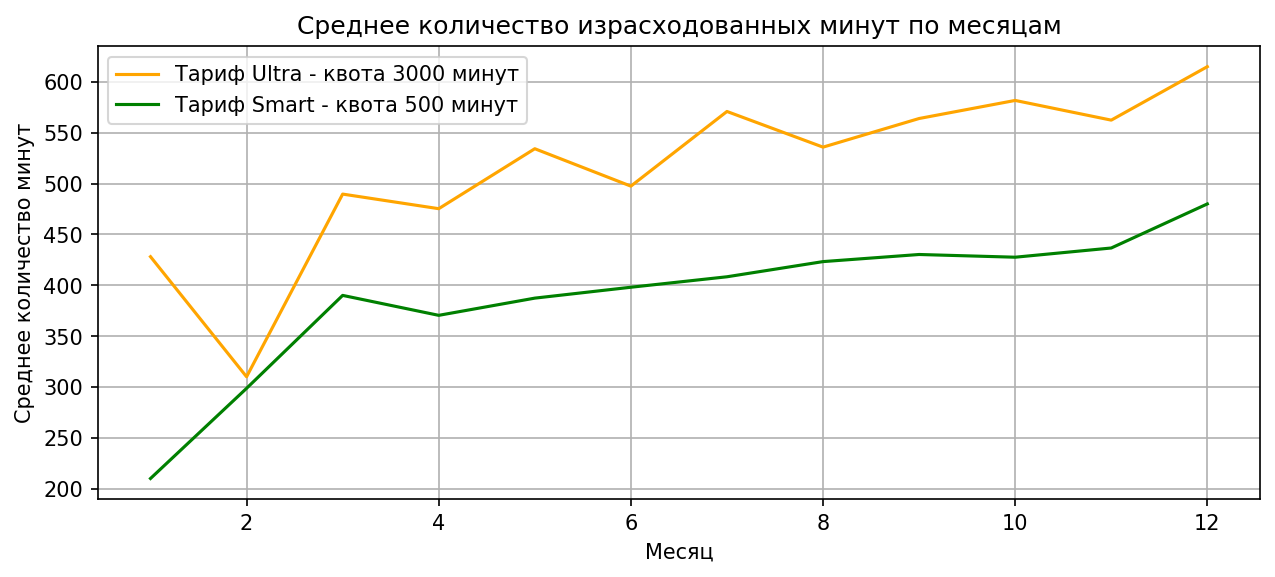

In [42]:
plt.figure(figsize=(10, 4), dpi=150)

plt.plot(
    df_all_data.query('tariff == "ultra"') # запросом срезаем данные только по тарифу ultra
    .pivot_table(index='month', values='sum_duration', aggfunc='mean'), # делаем сводную по среднему времени
    label='Тариф Ultra - квота 3000 минут', 
    color='orange') 

plt.plot(
    df_all_data.query('tariff == "smart"') # запросом срезаем данные только по тарифу smart
    .pivot_table(index='month', values='sum_duration', aggfunc='mean'), # делаем сводную по среднему времени
    label='Тариф Smart - квота 500 минут', 
    color='green')

plt.ylabel('Среднее количество минут')
plt.xlabel('Месяц')
plt.legend()
plt.grid()
plt.title('Среднее количество израсходованных минут по месяцам')

plt.show()

Пользователи тарифа `Ultra` в среднем пользуются голосовой связью больше чем пользователи тарифа `Smart`. Однако если смотреть данные пропорционально абонентской плате, то разница получается далеко не в 4 раза и среднему времени очень далеко до своего лимита бесплатных минут.

Пользователи тарифа `Smart` наоборот по среднему времени разговора в плотную приближаются к совему лимиту. Это говорит о том, что они используют бесплатные квоты более эффективно.

Так же мы видим плавный подъем активности на двух тарифах в течение года. Сложно сказать, с чем это связано.

Построим гистограммы, чтобы оценить распределение.

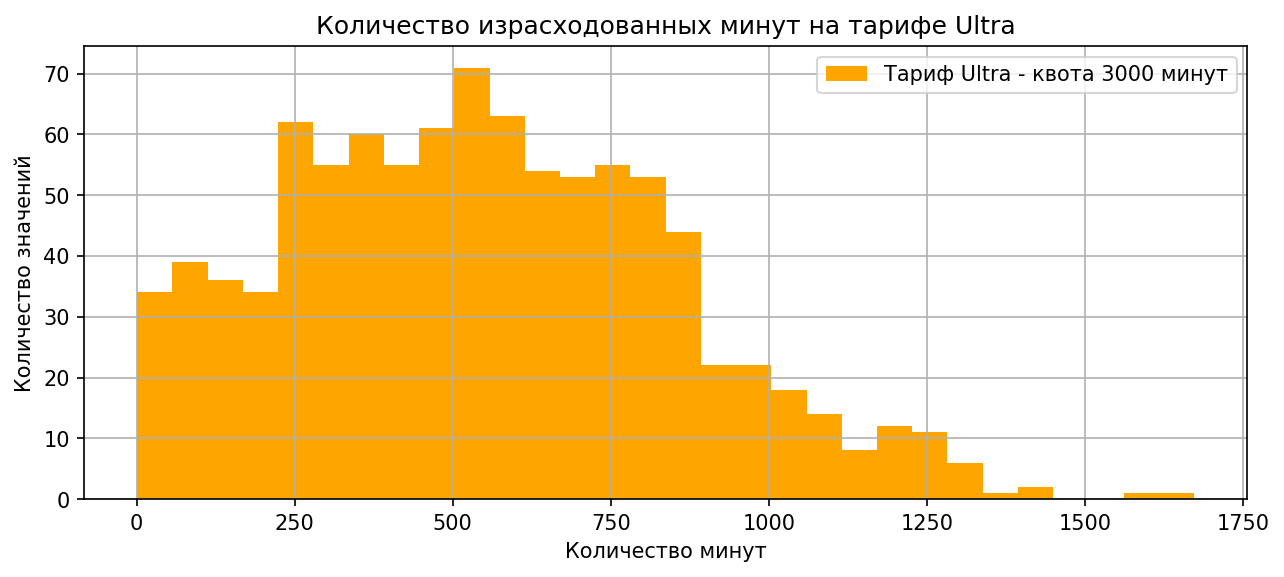

In [43]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "ultra"')['sum_duration'].hist(
    label='Тариф Ultra - квота 3000 минут', 
    bins=30, 
    color='orange')

plt.ylabel('Количество значений')
plt.xlabel('Количество минут')
plt.legend()
plt.title('Количество израсходованных минут на тарифе Ultra')

plt.show()

Видно, что ни один пользователь тарифа `Ultra` не исчерпал свой лимит звонков. Это говорит о том, что на тарифе предоставляется чрезмерная квота бесплатных звонков. Оснвной пул расхода лежит в отрезке 250-900 минут, пользователи крайне редко наговаривают больше.

Распределение немного смещено вправо. Это говорит нам о том, что пользователей, которые активно ползуются голосовой связью сильно меньше, чем тех кто наговоривает менее 1000 минут в месяц.

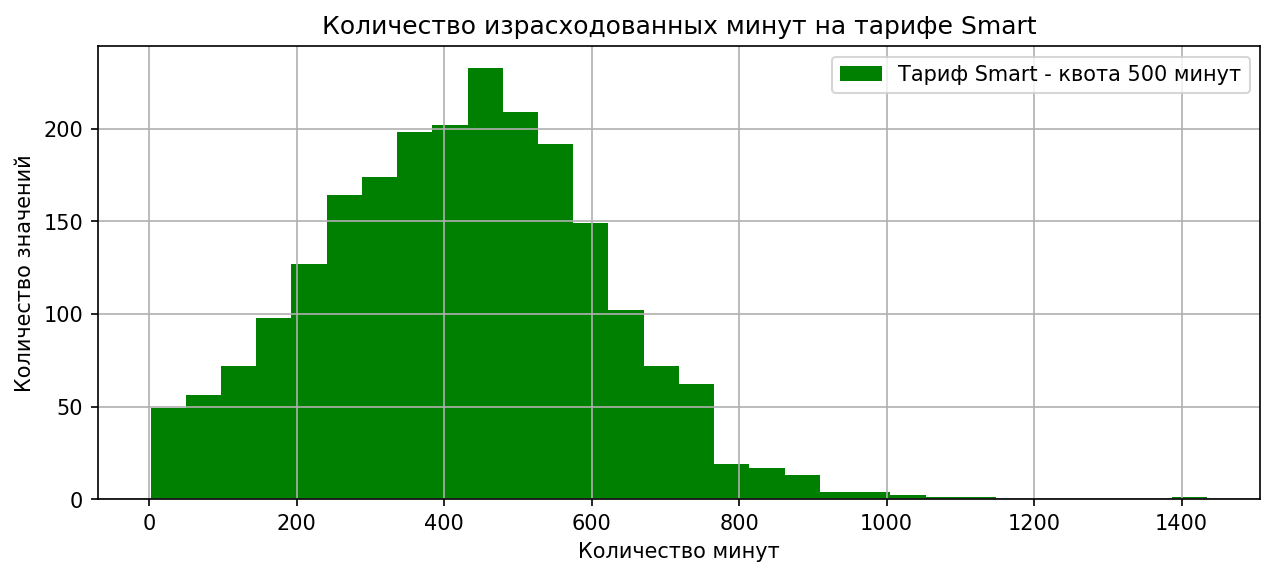

In [44]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "smart"')['sum_duration'].hist(
    label='Тариф Smart - квота 500 минут', 
    bins=30, 
    color='green')

plt.ylabel('Количество значений')
plt.xlabel('Количество минут')
plt.legend()
plt.title('Количество израсходованных минут на тарифе Smart')

plt.show()

По гистограмме видно, что основная часть пользователей тарифа `Smart` выговаривают свою бесплатную квоту, часто влезая в тарифицируюмую зону звонков.

Распределение достаточно сильно смещено вправо. Это говорит нам о том, что количество пользователей, которые готовы оплачивать тарифицируемые звонки и активно пользоваться голосовой связью значительно меньше тех, кто старается удержаться в бесплатной квоте.

Теперь найдем `среднее`, `стандартное отклонение` и `дисперсию` наших звоков:

In [45]:
# информацию о среднем, стандартном отклонении и дисперсии ищем следующим образом:
# с помощью логической индексации сразаем данные по нужному тарифу
# выбираем интересующий нас столбец
# считаем по нему интересующие значения, с помощью функций: .mean() np.std() np.var() соответственно.

print('Информация о длительности голосовой связи \n')

print('Тариф Ultra:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "ultra"]["sum_duration"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "ultra"]["sum_duration"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "ultra"]["sum_duration"]):.0f}')
print()

print('Тариф Smart:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "smart"]["sum_duration"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "smart"]["sum_duration"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "smart"]["sum_duration"]):.0f}')


Информация о длительности голосовой связи 

Тариф Ultra:
Среднее значение: 548
Стандартное отклонение: 305
Дисперсия: 93240

Тариф Smart:
Среднее значение: 419
Стандартное отклонение: 189
Дисперсия: 35702


<p style="text-align: center;"><b>Информация о длительности голосовой связи (минут)</b></p>

Тариф|Среднее|Ст. отклонение|Дисперсия
--|--|--|--
Ultra|548|305|93240
Smart|419|189|35702



<a id='research_02'></a>
### 4.2 Исследование количества сообщений пользователей [▴](#head)

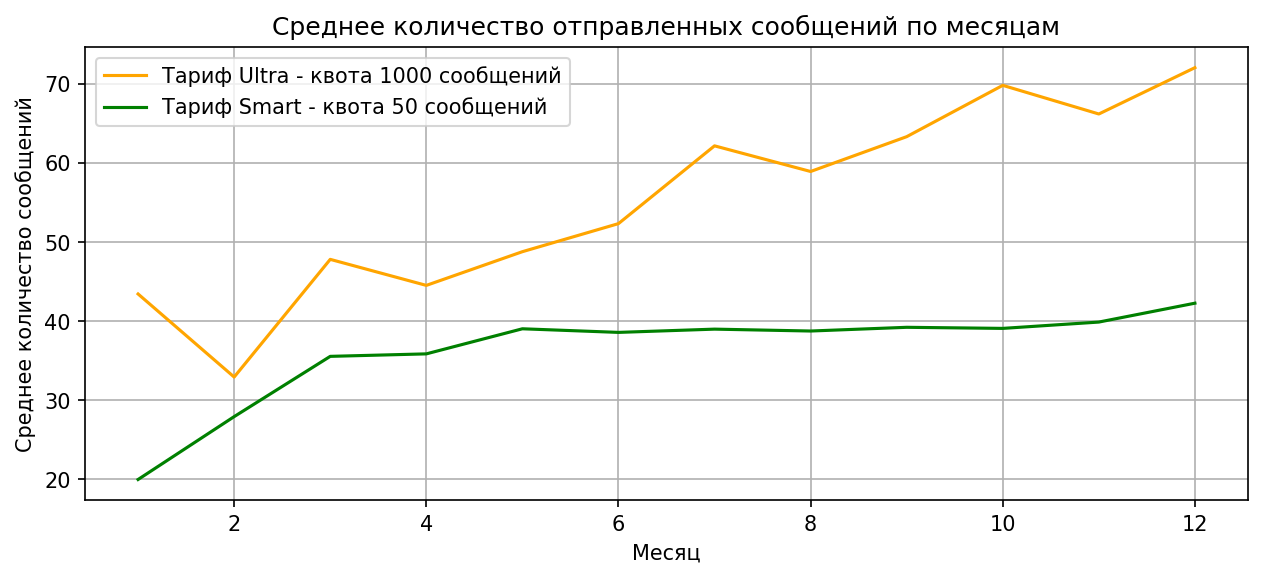

In [46]:
plt.figure(figsize=(10, 4), dpi=150)

plt.plot(
    df_all_data.query('tariff == "ultra"')
    .pivot_table(index='month', values='messages_cnt', aggfunc='mean'), 
    label='Тариф Ultra - квота 1000 сообщений', 
    color='orange')

plt.plot(
    df_all_data.query('tariff == "smart"')
    .pivot_table(index='month', values='messages_cnt', aggfunc='mean'), 
    label='Тариф Smart - квота 50 сообщений', 
    color='green')

plt.ylabel('Среднее количество сообщений')
plt.xlabel('Месяц')
plt.legend()
plt.grid()
plt.title('Среднее количество отправленных сообщений по месяцам')

plt.show()

Видно, что на тарифе `Ultra` сообщениями пользуются в среднем в 2 раза активнее чем на тарифе `Smart`, однако до своей квоты в 1000 сообщений им очень далеко.

Так же видно, что на тарифе `Ultra` активность пользователей в течение года равномерно растет, а на тарифе `Smart` остается примерно на том же уровне.

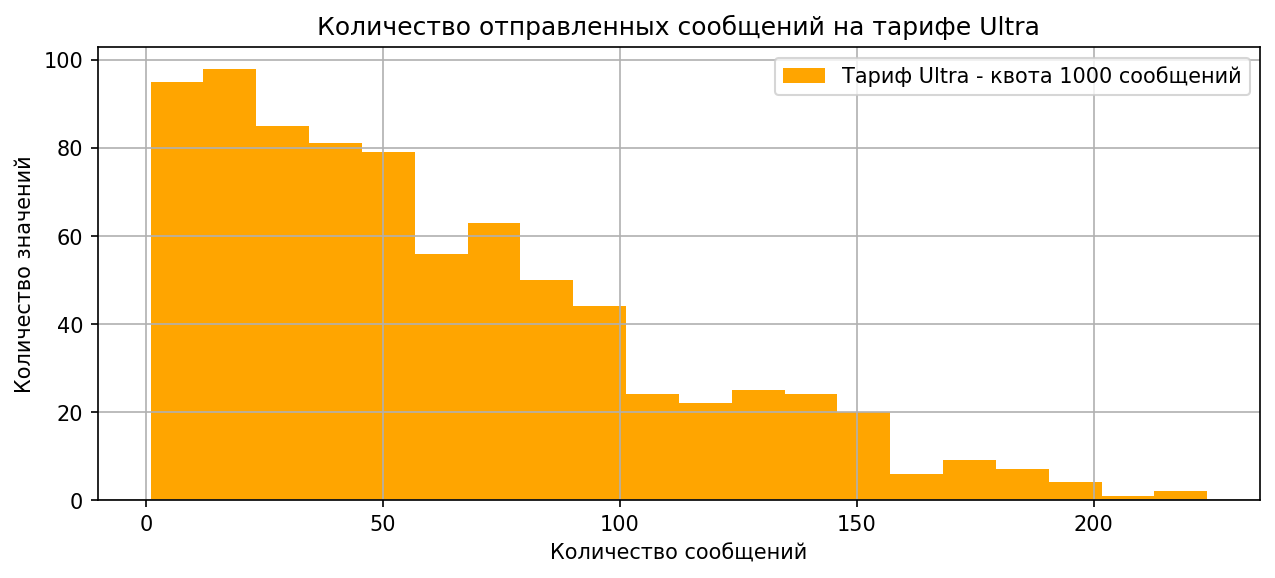

In [47]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "ultra"')['messages_cnt'].hist(
    label='Тариф Ultra - квота 1000 сообщений', 
    bins=20, 
    color='orange')

plt.ylabel('Количество значений')
plt.xlabel('Количество сообщений')
plt.legend()
plt.title('Количество отправленных сообщений на тарифе Ultra')

plt.show()

Распределение сильно смещено вправо, это говорит о том что большая часть пользователей крайне мало пользуются сообщениями. Бесплатная квота в 1000 сообщений как минимум в 5 раз перекрывает потребность пользователей в этом виде связи на тарифе `Ultra`

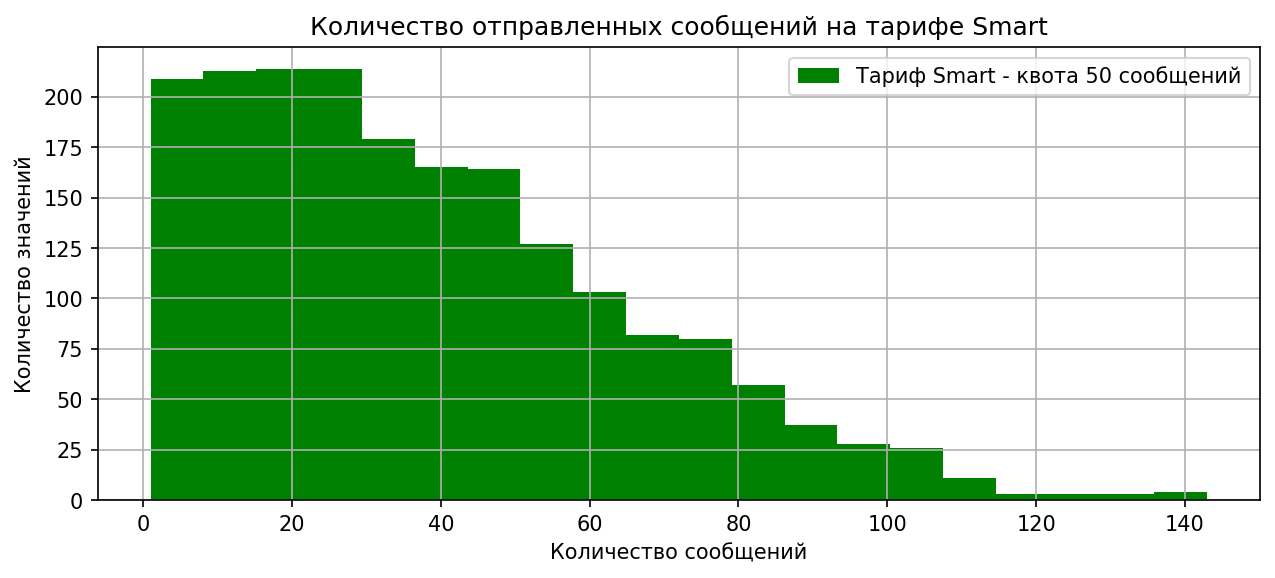

In [48]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "smart"')['messages_cnt'].hist(
    label='Тариф Smart - квота 50 сообщений', 
    bins=20, 
    color='green')

plt.ylabel('Количество значений')
plt.xlabel('Количество сообщений')
plt.legend()
plt.title('Количество отправленных сообщений на тарифе Smart')

plt.show()

По распределению видно, что пользователи достаточно часто преодолевают свой бесплатный лимит в 50 сообщений, переходя на тарифицируемые сообщения. Однако большая часть пользователей старается держаться в бесплатной квоте. 

Распределение сильно смещено вправо, что говорит о низкой популярности использования сообщений у пользователей.

In [49]:
print('Информация о количестве сообщений \n')

print('Тариф Ultra:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "ultra"]["messages_cnt"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "ultra"]["messages_cnt"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "ultra"]["messages_cnt"]):.0f}')

print()
print('Тариф Smart:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "smart"]["messages_cnt"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "smart"]["messages_cnt"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "smart"]["messages_cnt"]):.0f}')

print()

Информация о количестве сообщений 

Тариф Ultra:
Среднее значение: 61
Стандартное отклонение: 46
Дисперсия: 2107

Тариф Smart:
Среднее значение: 39
Стандартное отклонение: 27
Дисперсия: 717



<p style="text-align: center;"><b>Количество сообщений</b></p>

Тариф|Среднее|Ст. отклонение|Дисперсия
--|--|--|--
Ultra|61|46|2107
Smart|39|27|717



<a id='research_03'></a>
### 4.3 Исследование трафика пользователей [▴](#head)

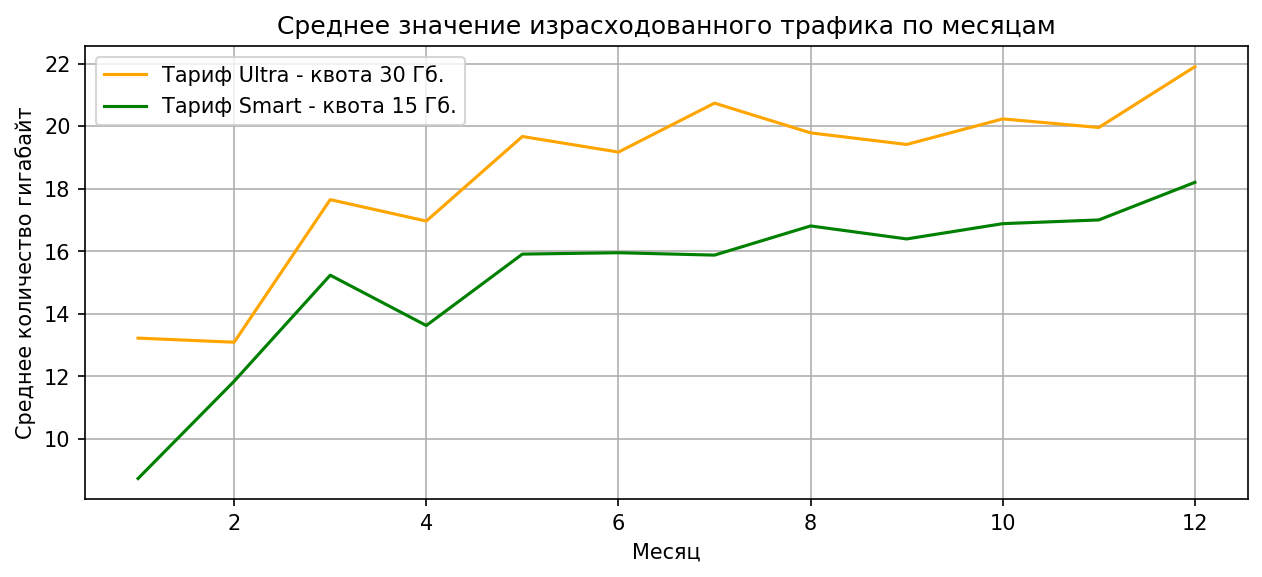

In [50]:
plt.figure(figsize=(10, 4), dpi=150)

plt.plot(
    df_all_data.query('tariff == "ultra"')
    .pivot_table(index='month', values='gb_used', aggfunc='mean'), 
    label='Тариф Ultra - квота 30 Гб.', 
    color='orange')

plt.plot(
    df_all_data.query('tariff == "smart"')
    .pivot_table(index='month', values='gb_used', aggfunc='mean'), 
    label='Тариф Smart - квота 15 Гб.', 
    color='green')

plt.ylabel('Среднее количество гигабайт')
plt.xlabel('Месяц')
plt.legend()
plt.grid()
plt.title('Среднее значение израсходованного трафика по месяцам')

plt.show()

Пользователи тарифа `Ultra` активнее пользоуются интернетом, чем пользователи тарифа `Smart`. При этом пользователи тарифа `Ultra` в основном держатся в своей бесплатной квоте трафика, а вот пользователям `Smart` наоборот, чаще нехватает квоты в 15 Гб. и они платят за дополнительный трафик.

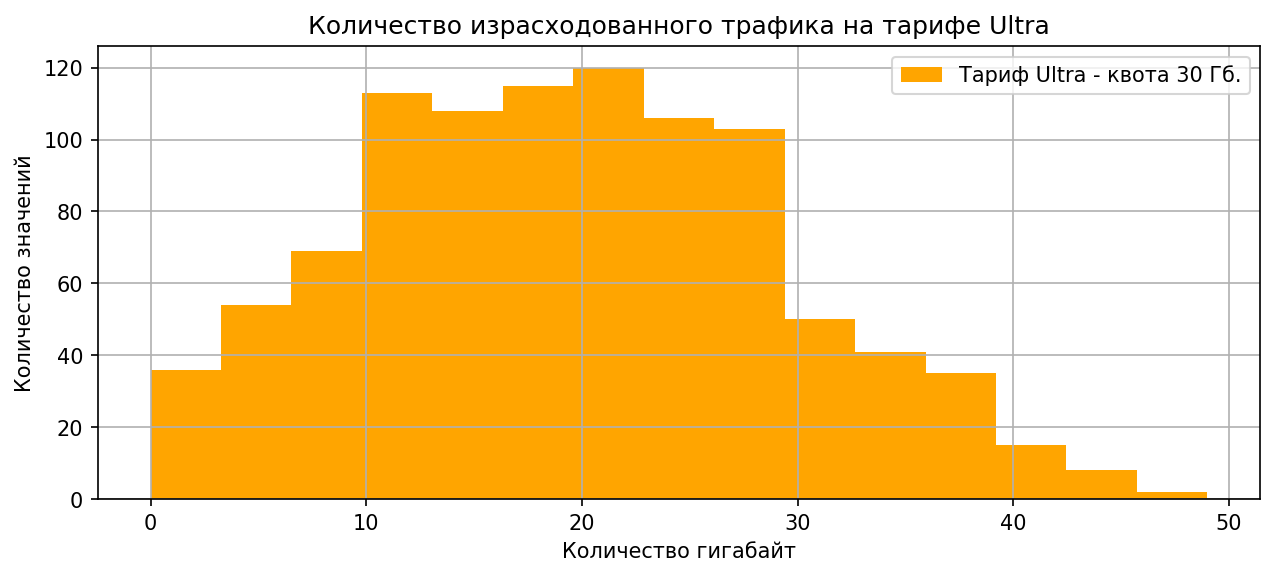

In [51]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "ultra"')['gb_used'].hist(
    label='Тариф Ultra - квота 30 Гб.', 
    bins=15, 
    color='orange')

plt.ylabel('Количество значений')
plt.xlabel('Количество гигабайт')
plt.legend()
plt.title('Количество израсходованного трафика на тарифе Ultra')

plt.show()

Данные распределены нормально, это говорит нам о том, что в среднем все пользователи активно пользуются интернетом. Небольшое смещение означает, что пользователи стараются держаться в бесплатной квоте и лишь небольшая часть вылезает за тарифицируемую зону.

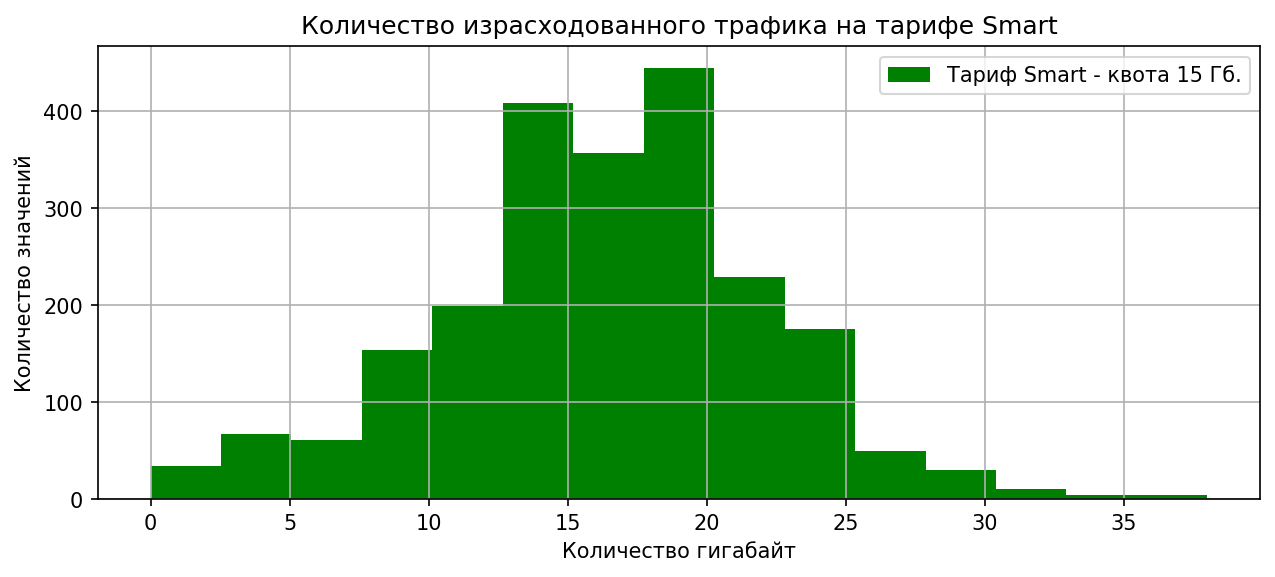

In [52]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "smart"')['gb_used'].hist(
    label='Тариф Smart - квота 15 Гб.', 
    bins=15, 
    color='green')

plt.ylabel('Количество значений')
plt.xlabel('Количество гигабайт')
plt.legend()
plt.title('Количество израсходованного трафика на тарифе Smart')

plt.show()

Данные распределены нормально, это означает что в среднем все пользователи активно пользуются интернетом. Так же мы видим, что в большинстве случаев пользователям нехватает бесплатфной квоты в 15 Гб. и они оплачивают дополнительный трафик по тарифу.

In [53]:
print('Информация о количестве трафика в Гб. \n')

print('Тариф Ultra:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "ultra"]["gb_used"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "ultra"]["gb_used"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "ultra"]["gb_used"]):.0f}')

print()
print('Тариф Smart:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "smart"]["gb_used"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "smart"]["gb_used"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "smart"]["gb_used"]):.0f}')

print()

Информация о количестве трафика в Гб. 

Тариф Ultra:
Среднее значение: 20
Стандартное отклонение: 10
Дисперсия: 94

Тариф Smart:
Среднее значение: 16
Стандартное отклонение: 6
Дисперсия: 33



<p style="text-align: center;"><b>Количество трафика в Гб.</b></p>

Тариф|Среднее|Ст. отклонение|Дисперсия
--|--|--|--
Ultra|20|10|94
Smart|16|6|33



<a id='research_04'></a>
### 4.4 Исследование выручки спользователей [▴](#head)

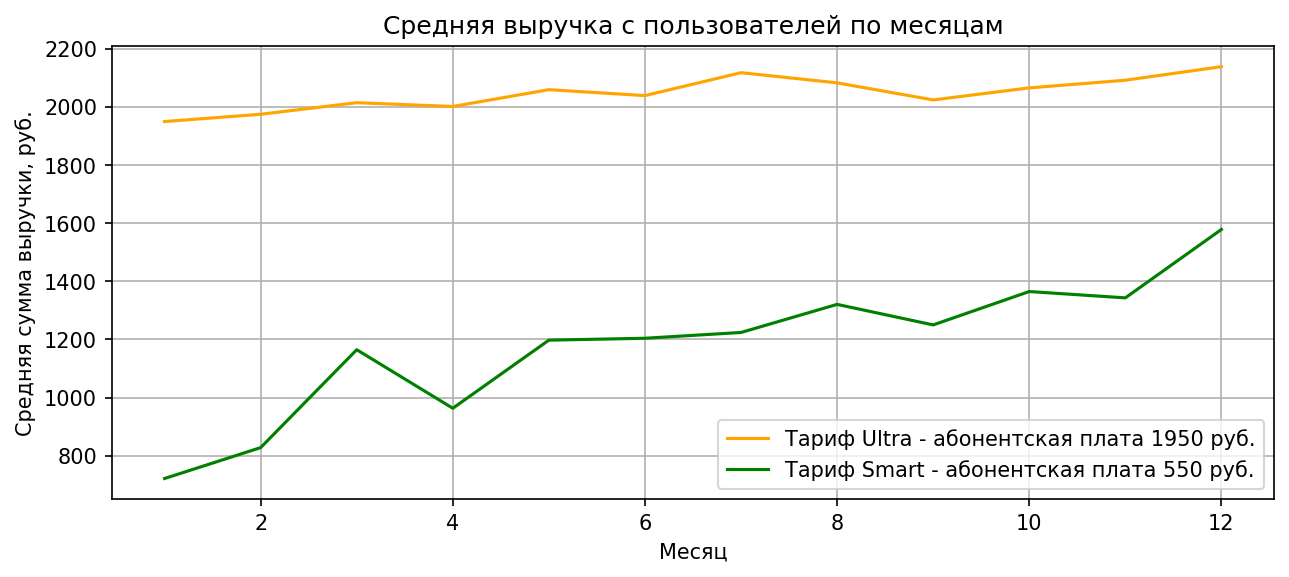

In [54]:
plt.figure(figsize=(10, 4), dpi=150)

plt.plot(
    df_all_data.query('tariff == "ultra"')
    .pivot_table(index='month', values='revenue', aggfunc='mean'), 
    label='Тариф Ultra - абонентская плата 1950 руб.', 
    color='orange')

plt.plot(
    df_all_data.query('tariff == "smart"')
    .pivot_table(index='month', values='revenue', aggfunc='mean'), 
    label='Тариф Smart - абонентская плата 550 руб.', 
    color='green')

plt.ylabel('Средняя сумма выручки, руб.')
plt.xlabel('Месяц')
plt.legend()
plt.grid()
plt.title('Средняя выручка с пользователей по месяцам')

plt.show()

На графике видно, что выручка от пользователей тарифа `Ultra` сильно превышает выручку от пользователей тарифа `Smart`

Для компании выгодней как можно большее количество пользователей переводить на подобный тариф, с высокой абонентской платой.

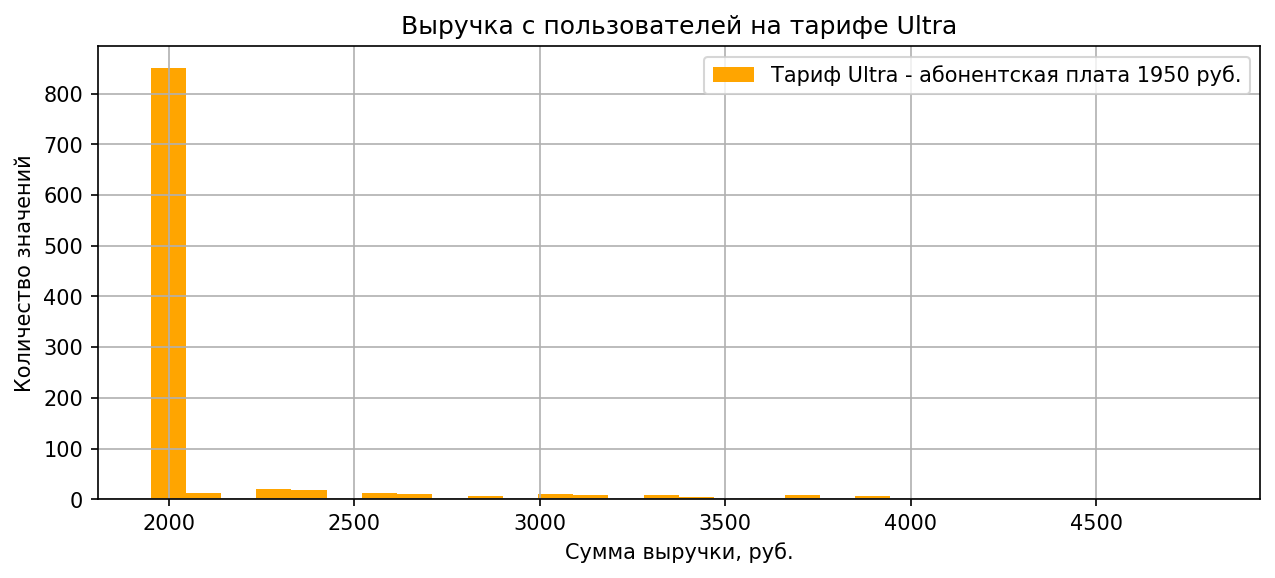

In [55]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "ultra"')['revenue'].hist(
    label='Тариф Ultra - абонентская плата 1950 руб.', 
    bins=30, 
    color='orange')

plt.ylabel('Количество значений')
plt.xlabel('Сумма выручки, руб.')
plt.legend()
plt.title('Выручка с пользователей на тарифе Ultra')

plt.show()

На гистограмме видно, что подавляющей части пользователей хватает бесплатных квот выделенных в тарифе `Ultra`. Так-же из предыдущих гистограм мы помним, что пользователи тарифа `Ultra` ни разу не вылезали за бесплатный лимит по звонкам и сообщениям. Следовательно все тарифицируемые переплаты только за интернет.

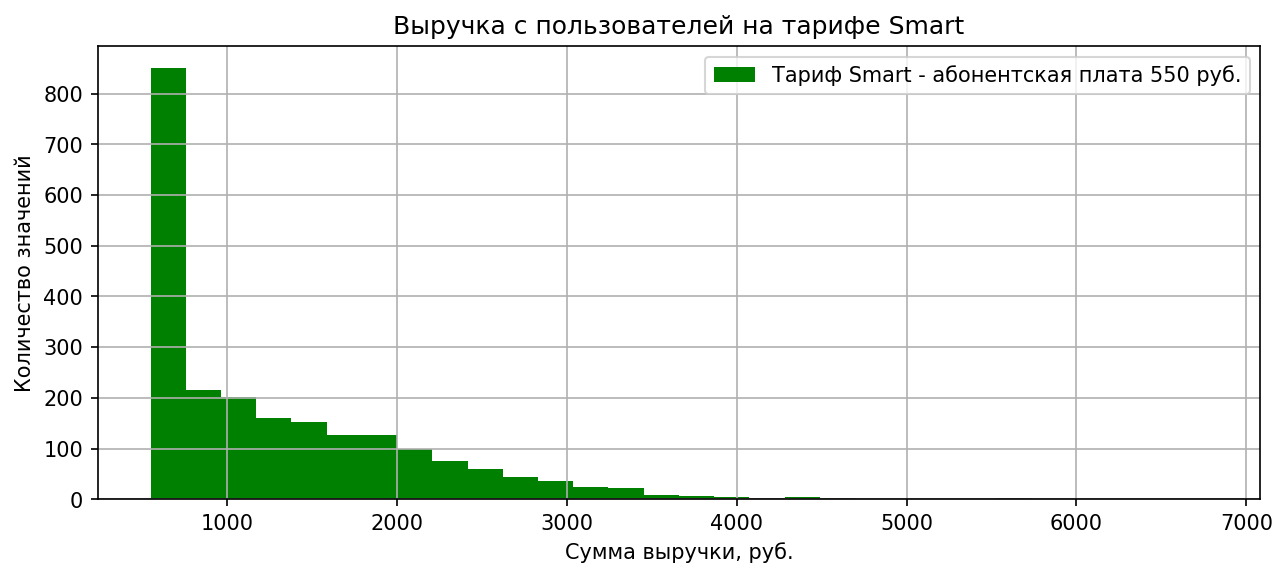

In [56]:
plt.figure(figsize=(10, 4), dpi=150)

df_all_data.query('tariff == "smart"')['revenue'].hist(
    label='Тариф Smart - абонентская плата 550 руб.', 
    bins=30, 
    color='green')

plt.ylabel('Количество значений')
plt.xlabel('Сумма выручки, руб.')
plt.legend()
plt.title('Выручка с пользователей на тарифе Smart')

plt.show()

По гистограмме видно, что несмотря на то, что ощутимая часть пользователей пользуется тарифом `Smart` в бесплатной квроде, все же большая часть пользователе вылезает за лимиты и оплачивает связь по тарифам.

Возможно тем пользователям, которые выходят за 2000 руб. в мес. стоило бы предложить тариф `Ultra` 

In [57]:
print('Информация о сумме выручки в руб. \n')

print('Тариф Ultra:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "ultra"]["revenue"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "ultra"]["revenue"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "ultra"]["revenue"]):.0f}')

print()
print('Тариф Smart:')
print(f'Среднее значение: {df_all_data[df_all_data["tariff"] == "smart"]["revenue"].mean():.0f}')
print(f'Стандартное отклонение: {np.std(df_all_data[df_all_data["tariff"] == "smart"]["revenue"]):.0f}')
print(f'Дисперсия: {np.var(df_all_data[df_all_data["tariff"] == "smart"]["revenue"]):.0f}')

print()

Информация о сумме выручки в руб. 

Тариф Ultra:
Среднее значение: 2070
Стандартное отклонение: 376
Дисперсия: 141373

Тариф Smart:
Среднее значение: 1290
Стандартное отклонение: 818
Дисперсия: 669485



<p style="text-align: center;"><b>Сумма выручки в руб.</b></p>

Тариф|Среднее|Ст. отклонение|Дисперсия
--|--|--|--
Ultra|2070|376|141373
Smart|1290|818|669485



<a id='research_conclusions'></a>
### Выводы [▴](#head)

- Тариф `Ultra` в среднем приносит больше прибыли для компании с одного пользователя. Было бы выгодно перевести на этот тариф как можно больше пользоватей компании.
- Наиболее активно пользователи используют интернет, это основной источник дохода при превышении лимитов на обоих тарифах.
- Менее активно пользуются звонками. На тарифе `Ultra` пользователи не вылезают за квоты вообще. На тарифе `Smart` превышают квоты незначительная часть пользователей.
- Совсем низкой популярностью пользуются сообщения. На тарифе `Ultra` бесплатные квоты не превышаются. На тарифе `Smart` лишь небольшая часть пользователей превышает квоты.

<a id='hypotheses'></a>
## 5. Проверка гипотез

##### <a id='hypotheses_01'></a>
### 5.1 Выручка от пользователей тарифов «Ультра» и «Смарт» [▴](#head)

Требуется проверить, различается ли средняя выручка пользователей тарифов `Ultra` и `Smart`.

Нам требуется проверить гипотезу о равенстве средних двух генеральных совокупностей, эти совокупности представляют собой выручку с тарифов `Ultra` и `Smart`. 

Для этого используем метод `scipy.stats.ttest_ind()`, так как выборки у нас разного размера, параметр `equal_var` установим в положение: `False`. Теперь сформируем нулевую и альтернативную гипотезы. Нулевая гипотеза всегда формируется так, чтобы использовался знак равенства, отсюда получаем:

- Гипотеза `H₀` - Выручка тарифов `Smart` равна выручке тарифов `Ultra`
- Гипотеза `H₁` - Выручка тарифов `Smart` и `Ultra` отличается

Первым делом получим выборки из нашего датасета

In [58]:
ultra_array = df_all_data.query('tariff == "ultra"')['revenue']
smart_array = df_all_data.query('tariff == "smart"')['revenue']

Проверим гипотезу

In [59]:
alpha = 0.01 # установим пороговое значение в 1%

results = st.ttest_ind(
    ultra_array, 
    smart_array, 
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


p-значение слишком мало, поэтому мы отвергаем нулевую гипотезу. Следовательно мы можем предсказать, что в генеральной совокупности выручка с тарифов `Ultra` и `Smart` отличается.

##### <a id='hypotheses_02'></a>
### 5.2 Выручка от пользователей из Москвы и других регионов [▴](#head)

Требуется проверить отличается ли средняя выручка пользователей из `Москвы` от выручки пользователей из `Других регионов`.

Нам требуется проверить гипотезу о равенстве средних двух генеральных совокупностей, эти совокупности представляют собой выручку с пользователей из `Москвы` и выручку с `Других регионов`. 

Для этого используем метод `scipy.stats.ttest_ind()`, так как выборки у нас разного размера, параметр `equal_var` установим в положение: `False`. Теперь сформируем нулевую и альтернативную гипотезы. Нулевая гипотеза всегда формируется так, чтобы использовался знак равенства, отсюда получаем:

- Гипотеза `H₀` - Выручка пользователей из `Москвы` равна выручке пользователей из `Других регионов`
- Гипотеза `H₁` - Выручка пользователей из `Москвы` отличается от выручки пользователей из `Других регионов`


Для начала получим необходимые срезы данных

In [60]:
moscow_array = (
    df_all_data[['user_id', 'revenue']].merge(df_users, on='user_id', how='left') # мерджим онформацию о регионе
    .query('city == "Москва"')['revenue'] # делаем срез по Москве и оставлем массив с данными о выручке
)

not_moscow_array = (
    df_all_data[['user_id', 'revenue']].merge(df_users, on='user_id', how='left') 
    .query('city != "Москва"')['revenue'] # делаем срез по остальным регионам и оставлем массив с данными о выручке
)

Проверим гипотезу

In [61]:
alpha = 0.01 # установим пороговое значение в 1%

results = st.ttest_ind(
    moscow_array, 
    not_moscow_array, 
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


У нас не получилось отвергнуть нулевую гипотезу, по всей видимости, в генеральной совокупности выручка пользователей из Москвы и других регионов примерно равна.

<a id='final_conclusion'></a>
## 6. Общий вывод

<a id='final_conclusion_01'></a>
### 6.1 Обзор данных [▴](#head)

При предварительном обзоре данных выяснилось, что предоставленные данные достаточно чистые, и требуют лишь небольших доработок в виде смены типов и пары манипуляций со столбцами.

Явных дубликатов ни в одной из таблиц не обнаружено. Все заголовки используют хороший стиль написания и не содержат пробелов, переименовывать их не нужно.

Данных в предоставленных таблицах оказалось достаточно для решения нашей задачи.

<a id='final_conclusion_02'></a>
### 6.2 Предобработка данных [▴](#head)

Была проведена следующая работа по предобработке данных:

**df_calls**
- `id` — переименовано в `call_id`
- `call_date` — дата преобразована из текста в `DateTime`
- `duration` — значение округлено до целовго вверх, произведена конвертация из `float64` в `int`

**df_internet**
- `id` — переименовано в `session_id`
- `Unnamed: 0` — удален
- `session_date` — дата преобразована из текста в `DateTime`

**df_messages**
- `id` — переименовано в `message_id`
- `message_date` — дата преобразована из текста в `DateTime`

**df_tariffs**
- действий не потребовалось

**df_users**
- `churn_date` — дата преобразована из текста в `DateTime`
- `reg_date` — дата преобразована из текста в `DateTime`


<a id='final_conclusion_03'></a>
### 6.3 Расчеты и дообогщение таблицы [▴](#head)

В ходе обогащения исходных данных были созданы новые таблицы:

- **`df_calls_details`** — содержит сводную информацию о времени звонков и их количестве по месяцам, минуты округлены до целых вверх за каждый звонок.
- **`df_messages_details`** — содержит сводную информацию о сообщениях по месяцам
- **`df_internet_details`** — содержит сводную информацию о интернет трафике по месяцам, трафик округлен до 1 гб вверх за каждый месяц.
- **`df_all_data`** — информация о звонках, сообщениях и трафике по месяцам с подсчетом выручки.
    - `user_id` — id ползователя
    - `year` — отчетный год
    - `month` — отчетный месяц
    - `messages_cnt` — количество сообщений
    - `sum_duration` — суммарное время разговора в месяц
    - `call_cnt` — соличество звонков в месяц
    - `mb_used` — трафик в мегабайтах использованный за месяц (округлен до 1 гб. наверх)
    - `gb_used` — трафик в гигабайтах использованный за месяц (округлен до 1 гб. наверх)
    - `tariff` — тарифный план
    - `messages_included` — количество сообщений включенных в тарифный план
    - `mb_per_month_included` — количество трафика включенных в тарифный план в мегабайтах
    - `minutes_included` — количество минут включенных в тарифный план
    - `rub_monthly_fee` — абонентская плата в месяц
    - `rub_per_gb` — стоимость 1 гигабайта трафика в руб. при превышении бесплатной квоты
    - `rub_per_message` — стоимость 1 сообщения в руб. при превышении бесплатной кывоты
    - `rub_per_minute` — стоимость 1 минуты разговора в руб. при превышении бесплатной квоты
    - `tariff_name` — тарифный план
    - `revenue` — суммарная выручка с каждого клиента за месяц, учитывая бесплатные квоты и стоимость тарифа

<a id='final_conclusion_04'></a>
### 6.4 Исследовательский анализ данных [▴](#head)

- Тариф `Ultra` в среднем приносит больше прибыли для компании с одного пользователя. Было бы выгодно перевести на этот тариф как можно больше пользоватей компании.
- Наиболее активно пользователи используют интернет, это основной источник дохода при превышении лимитов на обоих тарифах.
- Менее активно пользуются звонками. На тарифе `Ultra` пользователи не вылезают за квоты вообще. На тарифе `Smart` превышают квоты незначительная часть пользователей.
- Совсем низкой популярностью пользуются сообщения. На тарифе `Ultra` бесплатные квоты не превышаются. На тарифе `Smart` лишь небольшая часть пользователей превышает квоты.

<a id='final_conclusion_05'></a>
### 6.5 Проверка гипотез [▴](#head)

Нам требовалось проверить две гипотезы:
1. Средняя выручка пользователей тарифов `Ultra` и `Smart` различается
2. Средняя выручка пользователей из `Москвы` отличается от выручки пользователей из `Других регионов`.


**1) Мы сформировали нулевую и альтернативную гипотезу для первой задачи:**
- Гипотеза `H₀` - Выручка тарифов `Smart` равна выручке тарифов `Ultra`
- Гипотеза `H₁` - Выручка тарифов `Smart` и `Ultra` отличается

В итоге нулевая гипотеза была отвергнута. p-значение оказалось слишком мало. Следовательно мы можем предсказать, что в генеральной совокупности выручка с тарифов `Ultra` и `Smart` отличается.

**2) Для второй задачи были сформулированы следующие гипотезы:**
- Гипотеза `H₀` - Выручка пользователей из `Москвы` равна выручке пользователей из `Других регионов`
- Гипотеза `H₁` - Выручка пользователей из `Москвы` отличается от выручки пользователей из `Других регионов`

У нас не получилось отвергнуть нулевую гипотезу, по всей видимости, в генеральной совокупности выручка пользователей из Москвы и других регионов примерно равна.